### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import np_utils

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 



## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [14]:
# Paths for data.
Ravdess = "/Users/yeshnavya/Downloads/Data_Science/data_audio/RAVDESS/"
Crema = "/Users/yeshnavya/Downloads/Data_Science/data_audio/CREMA-D/"
Savee = "/Users/yeshnavya/Downloads/Data_Science/data_audio/SAVEE/"
Tess = "/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [21]:
ravdess_directory_list = os.listdir(Ravdess)

file_path = []
file_emotion=[]
for dir in ravdess_directory_list:
    # Skip files like .DS_Store
    if not os.path.isdir(os.path.join(Ravdess, dir)):
        continue
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
    
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
1     fear  /Users/yeshnavya/Downloads/Data_Science/data_a...
2     fear  /Users/yeshnavya/Downloads/Data_Science/data_a...
3    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
4  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [24]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
1    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
2  neutral  /Users/yeshnavya/Downloads/Data_Science/data_a...
3  neutral  /Users/yeshnavya/Downloads/Data_Science/data_a...
4  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...

##  <center> 3. TESS dataset <center>

In [27]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    # Check if it's a directory before listing contents
    if os.path.isdir(os.path.join(Tess, dir)):
        directories = os.listdir(os.path.join(Tess, dir))
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(os.path.join(Tess, dir, file))
    else:
        print(f"Skipping non-directory file: {dir}")

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()


Skipping non-directory file: .DS_Store


Emotions                                               Path
0  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...
1  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...
2  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...
3  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...
4  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...

##  <center> 4. SAVEE dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [30]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0       sad  /Users/yeshnavya/Downloads/Data_Science/data_a...
1       sad  /Users/yeshnavya/Downloads/Data_Science/data_a...
2   neutral  /Users/yeshnavya/Downloads/Data_Science/data_a...
3  surprise  /Users/yeshnavya/Downloads/Data_Science/data_a...
4   neutral  /Users/yeshnavya/Downloads/Data_Science/data_a...

In [32]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("/Users/yeshnavya/Downloads/Data_Science/data_audio/data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
1     fear  /Users/yeshnavya/Downloads/Data_Science/data_a...
2     fear  /Users/yeshnavya/Downloads/Data_Science/data_a...
3    angry  /Users/yeshnavya/Downloads/Data_Science/data_a...
4  disgust  /Users/yeshnavya/Downloads/Data_Science/data_a...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

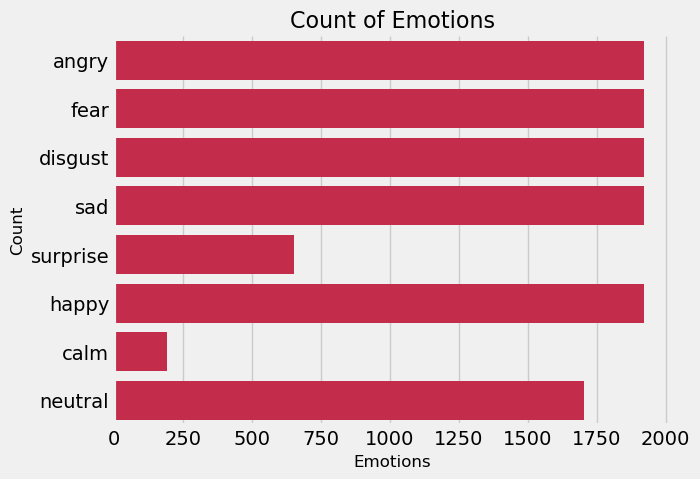

In [36]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions, color='crimson')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [39]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3), edgecolor='red')
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

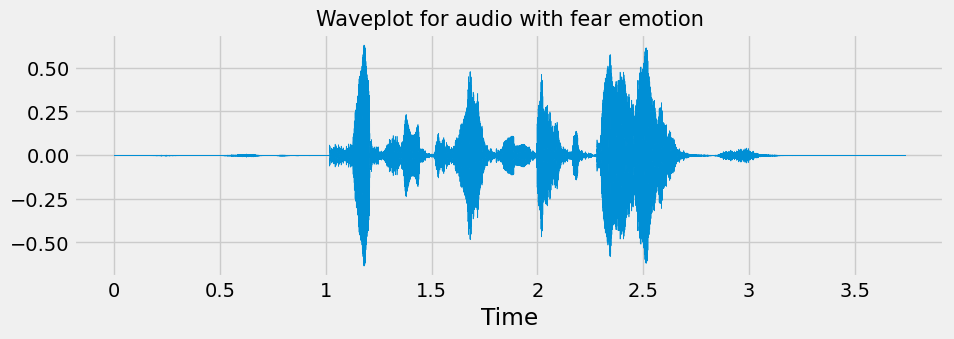

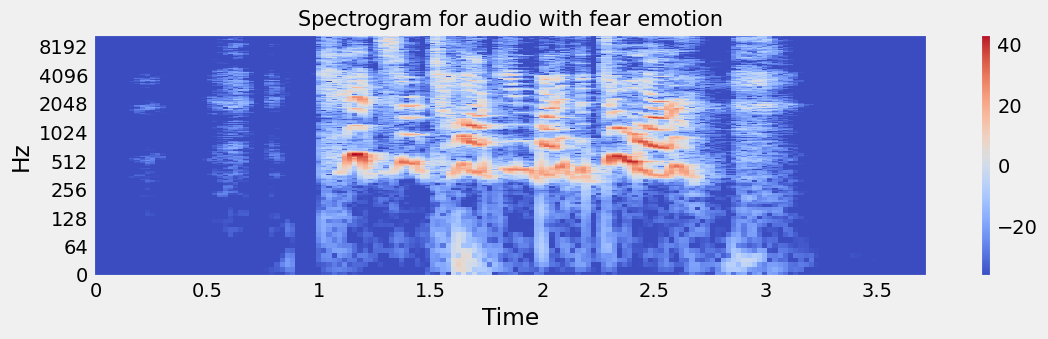

In [41]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

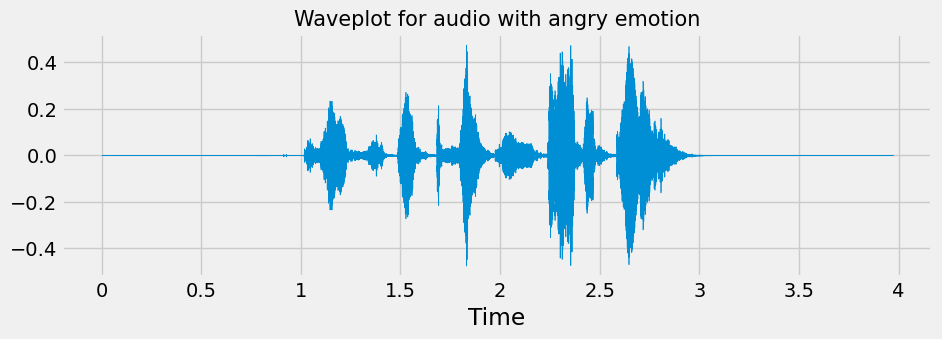

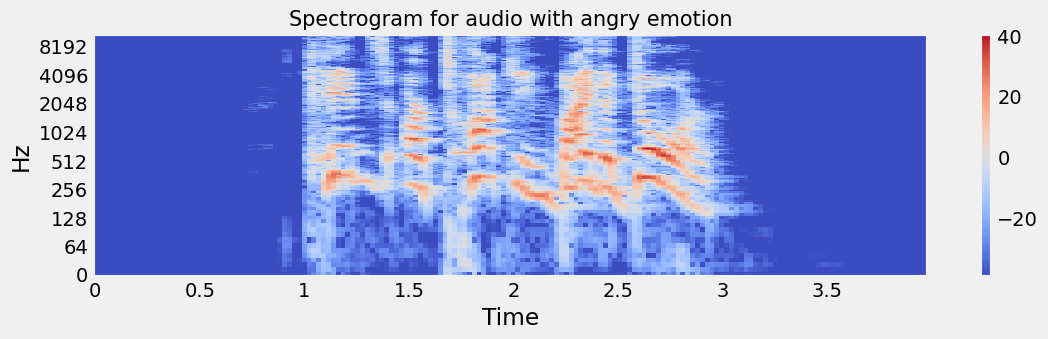

In [42]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

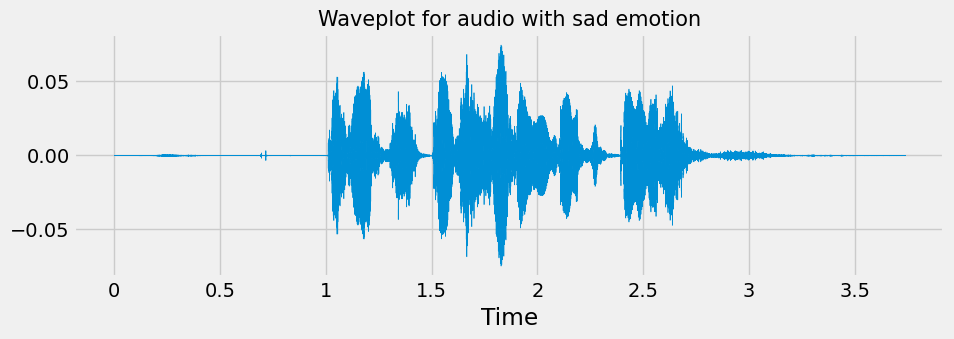

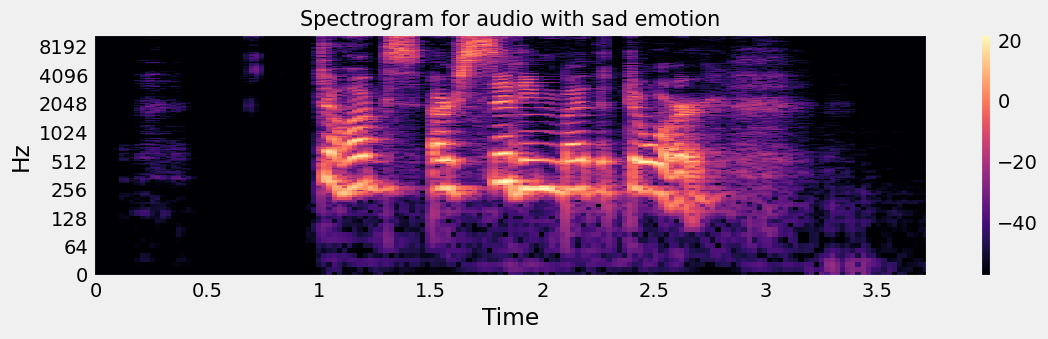

In [43]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

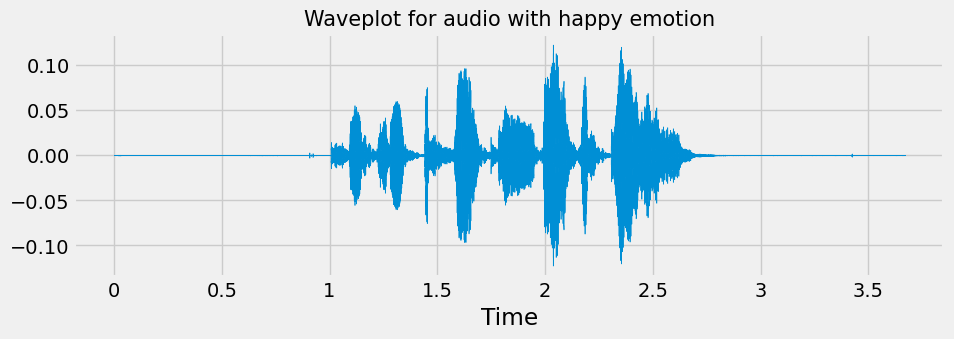

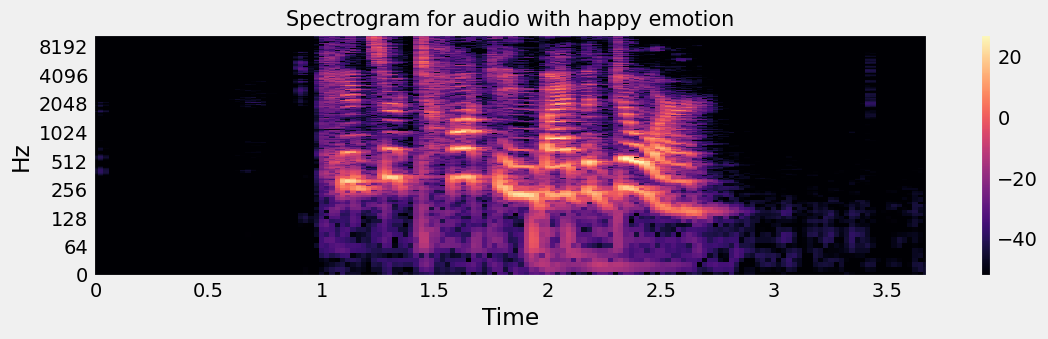

In [44]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [46]:
import scipy.signal

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def reverberation(data, sr, ir_signal):
    reverberated_audio= scipy.signal.convolve(data, ir_signal, mode='full')[:len(data)]
    return reverberated_audio/np.max(np.abs(reverberated_audio))

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def volume_perturbation(data, dB_change):
    perturbed_audio= data+dB_change
    return perturbed_audio
    
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

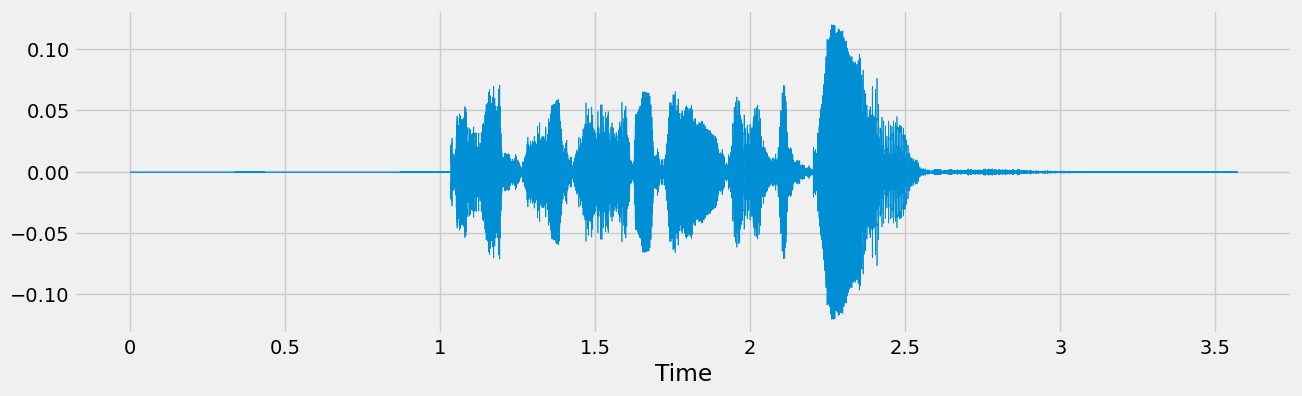

In [53]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

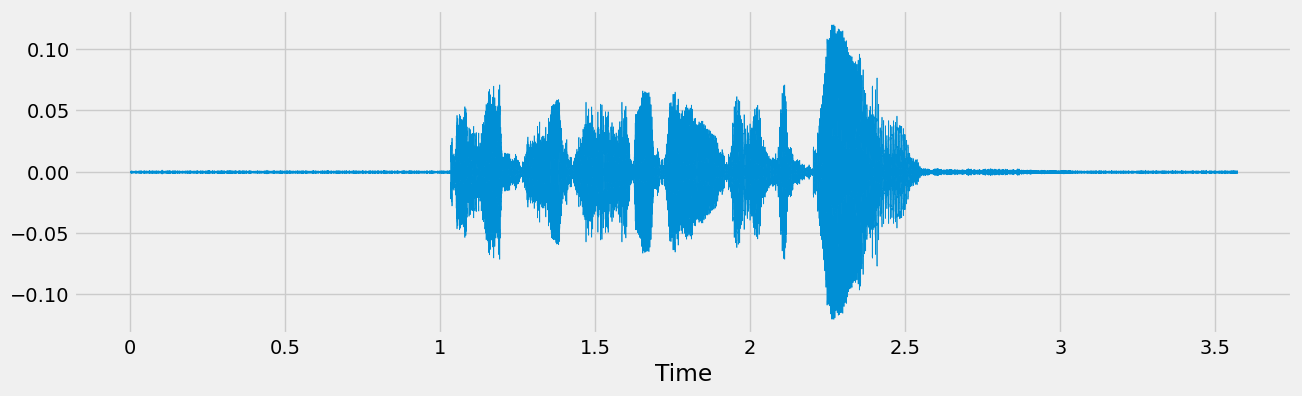

In [56]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

In [59]:
def generate_synthetic_ir(duration=2.0, sr=44100):
    t= np.linspace(0, duration, int(sr*duration))
    ir= np.exp(-3 * t)
    return ir

impulse_response=generate_synthetic_ir(duration=2.0, sr=sample_rate)

#### 3. Reverberating

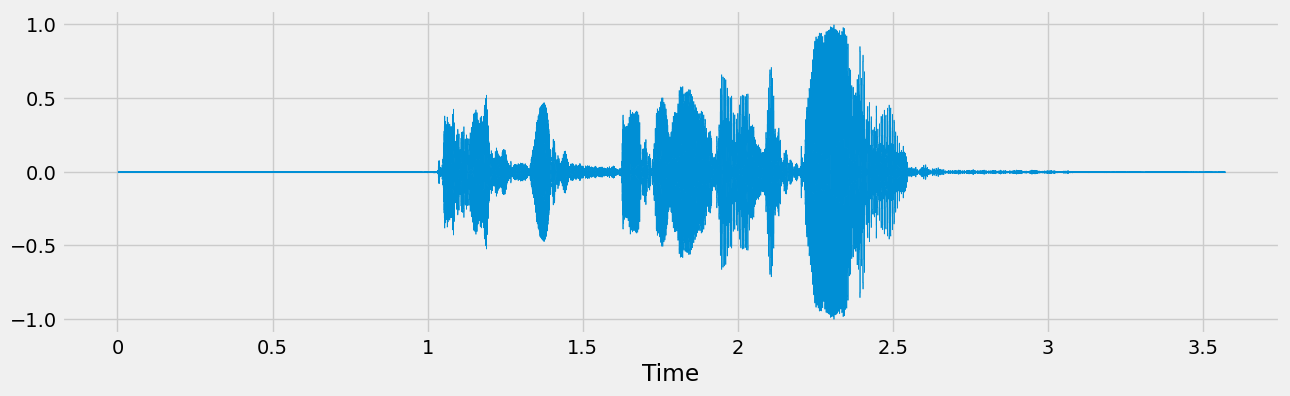

In [62]:
x = reverberation(data, sample_rate, impulse_response)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

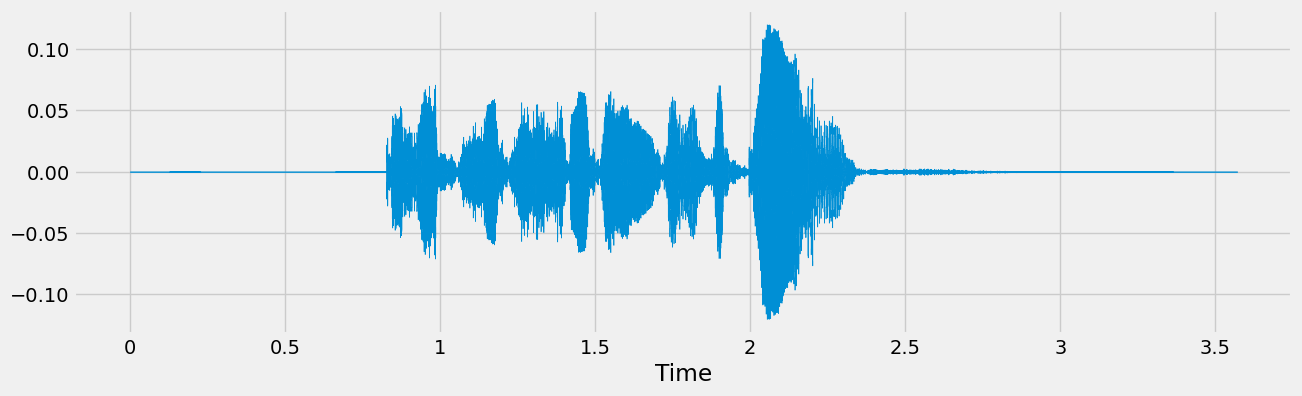

In [65]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Volume Perturbation

##### This simulates the real life scenario of operating model near a constant loudness device

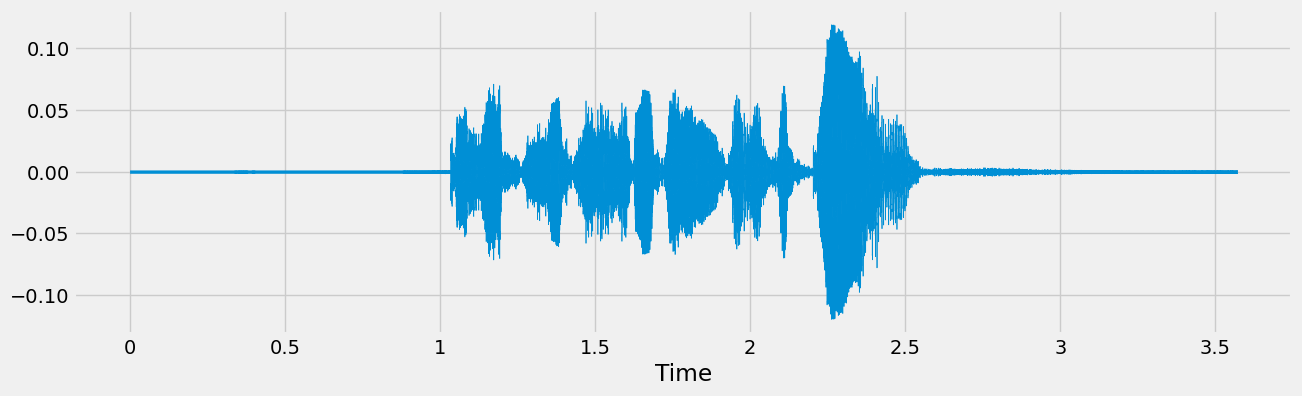

In [69]:
dB_change=0.001
x = volume_perturbation(data, dB_change)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

### Spectrogram creation 

##### Spectrogram is created for each audio for efficient training of model

In [75]:
def mel_spectrogram(data, n_mels=128, fmax=8000):
    mel_spec= librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=n_mels, fmax=fmax)
    #Log scale conversion
    mel_spec_dB= librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_dB

(128, 154)


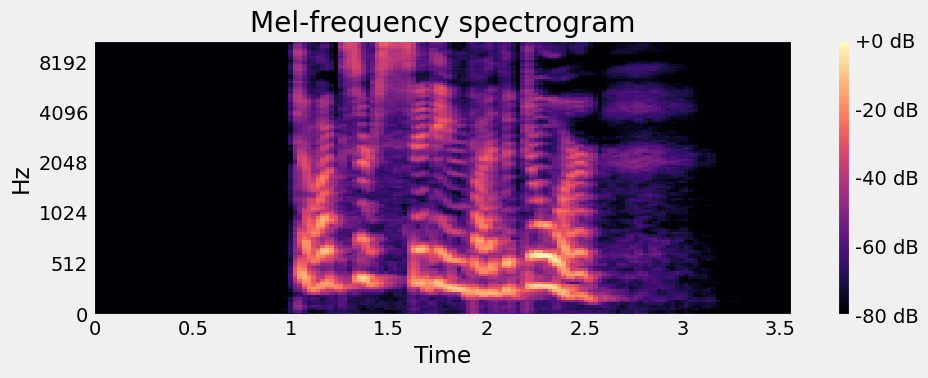

In [77]:
mel= mel_spectrogram(data)
print(mel.shape)
plt.figure(figsize=(10,4))
librosa.display.specshow(mel, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

## Integration Augmentation

In [128]:
class AudioAugmenter:
    """Class to handle audio augmentation techniques."""
    
    @staticmethod
    def noise(data, noise_factor=0.035):
        """Add random noise to the audio."""
        noise_amp = noise_factor * np.random.uniform() * np.amax(data)
        data = data + noise_amp * np.random.normal(size=data.shape[0])
        return data
    
    @staticmethod
    def reverberation(data, sr, ir_signal):
        """Add reverberation effect using impulse response."""
        reverberated_audio = scipy.signal.convolve(data, ir_signal, mode='full')[:len(data)]
        return reverberated_audio / np.max(np.abs(reverberated_audio))
    
    @staticmethod
    def shift(data, max_shift_ms=5):
        """Time shift the audio."""
        shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
        return np.roll(data, shift_range)
    
    @staticmethod
    def volume_perturbation(data, dB_change):
        """Adjust volume of the audio."""
        return data + dB_change
    
    @staticmethod
    def apply_random_augmentation(data, sr, ir_signal=None):
        """Apply random augmentation technique."""
        augmenter = AudioAugmenter()
        
        # List of available augmentations
        augmentations = [
            (augmenter.noise, {'noise_factor': np.random.uniform(0.01, 0.05)}),
            (augmenter.shift, {'max_shift_ms': np.random.uniform(3, 7)}),
            (augmenter.volume_perturbation, {'dB_change': np.random.uniform(-3, 3)})
        ]
        
        # Add reverberation only if IR signal is provided
        if ir_signal is not None:
            augmentations.append(
                (augmenter.reverberation, {'sr': sr, 'ir_signal': ir_signal})
            )
        
        # Randomly select an augmentation
        aug_func, aug_params = augmentations[np.random.randint(0, len(augmentations))]
        
        return aug_func(data, **aug_params)

## Integrating spectrometer generation

In [133]:
def process_audio_file(file_path, sample_rate=22050, n_mels=128, fmax=8000, 
                      augment=False, ir_signal=None):
    """Process a single audio file into mel spectrogram with optional augmentation."""
    try:
        # Load audio file
        data, sr = librosa.load(file_path, sr=sample_rate)
        
        # Apply augmentation if requested
        if augment:
            data = AudioAugmenter.apply_random_augmentation(data, sr, ir_signal)
        
        # Create mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=data,
            sr=sample_rate,
            n_mels=n_mels,
            fmax=fmax
        )
        
        # Convert to log scale
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
        
        # Resize spectrogram
        mel_spec_resized = tf.image.resize(mel_spec[..., tf.newaxis], [128, 154])
        
        # Expand to 3 channels
        mel_spec_rgb = tf.repeat(mel_spec_resized, repeats=3, axis=-1)
        
        return mel_spec_rgb.numpy()
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None


### Dataset Creation

### Data Splitting

#### Interesting Observations
- Spectrograms are not stored individually
- Instead paths are stored, the spectrograms are formed for each evaluation (on spot) thus reducing the storage requirements and speeding the training and testing process significantly

In [135]:
def prepare_dataset(file_paths, labels, sample_rate=22050, n_mels=128, fmax=8000, 
                   augment=False, augment_factor=2):
    """Prepare dataset with optional augmentation."""
    processed_specs = []
    valid_labels = []
    
    for file_path, label in zip(file_paths, labels):
        # Process original audio
        spec = process_audio_file(file_path, sample_rate, n_mels, fmax)
        if spec is not None:
            processed_specs.append(spec)
            valid_labels.append(label)
            
            # Add augmented versions if requested
            if augment:
                for _ in range(augment_factor - 1):
                    aug_spec = process_audio_file(
                        file_path, sample_rate, n_mels, fmax, 
                        augment=True
                    )
                    if aug_spec is not None:
                        processed_specs.append(aug_spec)
                        valid_labels.append(label)
    
    return np.array(processed_specs), np.array(valid_labels)

#### Splits have been made as follows:
- 80% Training Set ---- 20% Testing Set
- 80% Training Set ---- 20% Validation Set

In [166]:
def prepare_data_splits(data_path, emotion_to_num, augment_train=True):
    """Prepare train/validation/test splits with corrected labels."""
    # Prepare paths and labels
    valid_paths, one_hot_labels = prepare_labels(data_path, emotion_to_num)
    
    # Split into train/val/test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        valid_paths, one_hot_labels, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42
    )
    
    # Process audio files for each split
    X_train_processed, y_train_processed = prepare_dataset(
        X_train, y_train, augment=augment_train, augment_factor=2
    )
    X_val_processed, y_val_processed = prepare_dataset(X_val, y_val)
    X_test_processed, y_test_processed = prepare_dataset(X_test, y_test)
    
    return (X_train_processed, y_train_processed,
            X_val_processed, y_val_processed,
            X_test_processed, y_test_processed)

## Building Models -- Integrating the pipeline

In [195]:
def build_model(model_type='resnet', learning_rate=0.01):
    """Build model architecture."""
    model = tf.keras.Sequential()
    if model_type == 'resnet':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(128, 154, 3)
        )
    elif model_type == 'efficientnet':
        base_model = EfficientNetB7(
            weights='imagenet',
            include_top=False,
            input_shape=(128, 154, 3)
        )
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Hyperparameter Tuning
### GridSearchCV method (in-built)
- This method picks between the various optimal choices the most optimal one
- Helps in deciding the best route parameters for training the model on

In [205]:
def run_grid_search(X_train, y_train):
    """Perform grid search with specified parameters."""
    model = KerasClassifier(
        build_fn=build_model,
        verbose=0
    )
    
    param_grid = {
        'batch_size': [16, 32],
        'epochs': [10, 15, 20],
    }
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        verbose=2,
        n_jobs=-1
    )
    
    grid_result = grid.fit(X_train, y_train)
    return grid_result

## Using above defined functions

In [ ]:
def prepare_labels(data_path, emotion_to_num):
    """
    Prepare labels from the data paths.
    Assumes the emotion label can be extracted from the path.
    """
    labels = []
    valid_paths = []
    
    for path in data_path['Path']:
        for emotion in emotion_to_num.keys():
            if emotion in path:
                labels.append(emotion_to_num[emotion])
                valid_paths.append(path)
                break 
    
    # Convert to numpy arrays
    labels = np.array(labels)
    valid_paths = np.array(valid_paths)
    
    # Convert to one-hot encoding
    one_hot_labels = to_categorical(labels, num_classes=len(emotion_to_num))
    print(valid_paths)
    return valid_paths, one_hot_labels

In [ ]:
if __name__ == "__main__":
    # Define emotion mappings
    emotion_to_num = {
        "angry": 0, "fear": 1, "disgust": 2, "sad": 3,
        "surprise": 4, "happy": 5, "calm": 6, "neutral": 7
    }
    emotion_names = list(emotion_to_num.keys())

    # Prepare data with augmentation
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_splits(
        data_path, emotion_to_num, augment_train=True
    )
    
    # Run grid search
    grid_result = run_grid_search(X_train, y_train)
    
    # Print results
    print("Best parameters found:", grid_result.best_params_)
    print("Best cross-validation score:", grid_result.best_score_)
    
    # Save best model
    best_model = grid_result.best_estimator_

['/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/YAF_disgust/YAF_date_disgust.wav'
 '/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/YAF_disgust/YAF_rag_disgust.wav'
 '/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/YAF_disgust/YAF_raise_disgust.wav'
 ...
 '/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/OAF_Sad/OAF_met_sad.wav'
 '/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/OAF_Sad/OAF_pearl_sad.wav'
 '/Users/yeshnavya/Downloads/Data_Science/data_audio/TESS/OAF_Sad/OAF_rain_sad.wav']
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/anaconda3/lib/python3.12/si

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 60s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 61s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 64s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 64s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 66s 1us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 67s 1us/step


In [ ]:
grid_result.best_params
grid_result.best_score

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.